<h2> Pasos que se realizan en ambas plataformas:
    
<h3> 
    
*  Importar librerías

*  Validar uso de GPU

*  Obtención de datos y separación de conjunto de entrenamiento y prueba

*  Definición de las clases del entrenamiento

*  Definición de tamaño de batches a usar y épocas

*  Limpieza de caché



In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
#Importe de librerias:
import gc
import os
import numpy as np
import matplotlib.pyplot as plt
import time
#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#Tensor flow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Resizing, Input
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

save_directory = './Models'  # Puedes cambiar esta ruta a cualquier ruta que desees

def limpiar_cache():
  tf.keras.backend.clear_session()
  #Recursos de GPU# Verificar si hay soporte para CUDA (NVIDIA)
  if torch.cuda.is_available():
      torch.cuda.empty_cache()
  # Verificar si hay soporte para Metal (solo en Macs con M1 o posteriores)
  elif torch.backends.mps.is_available():
     torch.mps.empty_cache()
  # Si no hay soporte para CUDA ni Metal, usar CPU
  gc.collect()

#Recursos de GPU# Verificar si hay soporte para CUDA (NVIDIA)
if torch.cuda.is_available():
    device_torch = torch.device("cuda")
# Verificar si hay soporte para Metal (solo en Macs con M1 o posteriores)
elif torch.backends.mps.is_available():
    device_torch = torch.device("mps")
# Si no hay soporte para CUDA ni Metal, usar CPU
else:
    device_torch = torch.device("cpu")

#Tensorflow
device_tf = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

#Obtención de data y separación de conjuntos de entrenamiento y test
locBatchSize = 64
epochs = 30
epochs_pretrained = 10

#Pytorch
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=locBatchSize,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=locBatchSize,
                                         shuffle=False, num_workers=2)
#Tensor flow
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

#Clases del modelo:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<h2> Pasos genericos de entrenamiento de tensor flow:
<h3>

*  Definir  optimizador y criterio de pérdida.


*  Entrenar con datos de entrenamiento.


*  Guardar el modelo como opcional.


*  Evalar la precisión del modelo con datos de prueba.


In [2]:
def train_model_tf(model_fn, model_name, train_images, train_labels,
                   test_images, test_labels, epochs, locBatchSize, save=False, no_def=False, dropout_scheduler=None):
    start_time = time.time()  # Tiempo de inicio
    # Crear el modelo con la función que se pase como parámetro
    if no_def:
        model= model_fn
    else:
        model = model_fn()

    #Imprimir número de parametros:
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    total_trainable_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_variables)
    print(f"Modelo {model_name} tiene {total_trainable_params} parámetros entrenables.")

    # Entrenar el modelo
    if dropout_scheduler is None:
        history = model.fit(train_images, train_labels, epochs=epochs,
                            batch_size=locBatchSize,
                            validation_data=(test_images, test_labels))
    else:
        history = model.fit(train_images, train_labels, epochs=epochs,
                            batch_size=locBatchSize,
                            validation_data=(test_images, test_labels),callbacks=[dropout_scheduler])
    if save:
      #Definir ruta
        model_save_path = os.path.join(save_directory, f"{model_name}.h5")
        try:
            # Guardar el modelo
            model.save(model_save_path)
        except Exception as e:
            print(f"Ocurrió un error: {e}")
    else:
        pass
    
    #Precisión
    # Obtener la precisión de validación final desde el history
    final_val_acc = history.history['val_accuracy'][-1]  # Último valor de la precisión en validación
    # Imprimir precisión final de validación
    print(f'\nFinal validation accuracy: {final_val_acc * 100:.2f}%, {model_name}')
    
    # Evaluación por clase (sin necesidad de cargar el modelo nuevamente)
    class_accuracy = np.zeros(10)
    class_counter = np.zeros(10)
    # Obtener las predicciones
    predictions = np.argmax(model.predict(test_images), axis=1)
    true_labels = np.argmax(test_labels, axis=1)
    # Calcular la precisión por clase
    for i in tqdm(range(len(true_labels)), desc="Calculando precisión por clase", ncols=100, unit="ítem"):
        class_counter[true_labels[i]] += 1
        if predictions[i] == true_labels[i]:
            class_accuracy[true_labels[i]] += 1
    # Imprimir precisión por clase
    for i in tqdm(range(10), desc="Imprimiendo resultados", ncols=100, unit="clase"):
        print(f'Accuracy for class {classes[i]}: {100 * class_accuracy[i] / class_counter[i]:.2f}%, {model_name}')
        
    # Tiempo de ejecución total
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTiempo total de ejecución: {execution_time:.2f} segundos, {model_name}")

    #Ver en grafico el compartamiento de precisión por época.
    acc=history.history["accuracy"]
    val_acc=history.history["val_accuracy"]
    epo=range(1,len(acc)+1)
    
    # Crear el gráfico
    fig, ax = plt.subplots()
    # Usar scatter para los puntos
    ax.scatter(epo, acc, color='blue', label=f'Precisión del entrenamiento del modelo: {model_name}')
    ax.scatter(epo, val_acc, color='purple', label=f'Precisión del test del modelo: {model_name}')
    # Unir los puntos con líneas
    ax.plot(epo, acc, color='blue', linestyle='-', linewidth=1)
    ax.plot(epo, val_acc, color='purple', linestyle='-', linewidth=1)
    # Etiquetas y título
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Precisión')
    ax.set_title(f'Precisión del modelo {model_name} durante el entrenamiento y la validación')
    # Añadir leyenda debajo del eje X
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    # Mostrar gráfico
    plt.show()
    
    limpiar_cache()



<h2> Pasos genericos de entrenamiento de PyTorch:
<h3>

*  Definir optimizador y criterio de pérdida.

*  Entrenar con datos de entrenamiento.


*  Guardar el modelo como opcional.


*  Evalar la precisión del modelo con datos de prueba.

In [3]:
# Función para contar los parámetros del modelo
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_model_torch(model_class, model_name, trainloader,
                             testloader, epochs, batch_size, save=False, no_class=False):
    start_time = time.time()
    
    # Inicializar el modelo
    if no_class:
        model = model_class.to(device_torch)
    else:
        model = model_class().to(device_torch)

    print(f"Modelo {model_name} tiene {count_params(model)} parámetros entrenables.")

    # Optimizer y criterio de pérdida
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()



    # Entrenamiento y validación
    # Inicializar el objeto history para almacenar las métricas
    history = {
        'accuracy': [],
        'val_accuracy': [],
    }
    #Entrenamiento
    for epoch in range(epochs):
        model.train()  # Configurar el modelo en modo entrenamiento
        correct_train = 0
        total_train = 0
        class_success = [0] * 10
        class_counter = [0] * 10
        running_loss = 0.0
    
        # Iterar sobre el conjunto de entrenamiento
        with tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f'Epoch {epoch + 1}/{epochs}', ncols=100) as pbar:
            for i, data in pbar:
                inputs, labels = data[0].to(device_torch), data[1].to(device_torch)
    
                optimizer.zero_grad()
    
                # Forward + Backward + Optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                running_loss += loss.item()
    
                # Calcular precisión de entrenamiento
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)
    
                # Calcular precisión por clase
                for i in range(len(labels)):
                    class_success[labels[i]] += (predicted[i] == labels[i]).item()
                    class_counter[labels[i]] += 1
    
                # Actualizar barra de progreso de tqdm
                pbar.set_postfix(loss=running_loss / (i+1), accuracy=correct_train / total_train)
    
        # Guardar precisión general de entrenamiento por epoca
        train_accuracy = correct_train / total_train * 100
        history['accuracy'].append(train_accuracy)
    
        # Validación
        model.eval()  # Configurar el modelo en modo evaluación
        correct_val = 0
        total_val = 0
        class_success = [0] * 10
        class_counter = [0] * 10
    
        with torch.no_grad():
            with tqdm(enumerate(testloader, 0), total=len(testloader), desc=f'Validating Epoch {epoch + 1}/{epochs}', ncols=100) as pbar_val:
                for i, data in pbar_val:
                    inputs, labels = data[0].to(device_torch), data[1].to(device_torch)
                    outputs = model(inputs)
    
                    # Calcular precisión de validación
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
    
                    # Calcular precisión por clase de validación
                    for i in range(len(labels)):
                        class_success[labels[i]] += (predicted[i] == labels[i]).item()
                        class_counter[labels[i]] += 1
    
                    # Actualizar barra de progreso de tqdm
                    pbar_val.set_postfix(val_accuracy=correct_val / total_val)
    
        # Guardar precisión general de validación
        val_accuracy = correct_val / total_val * 100
        history['val_accuracy'].append(val_accuracy)

        if epoch==len(range(epochs))-1: 
            print(f'Training accuracy for epoch {epoch + 1}, {val_accuracy:.2f}%, {model_name}')
            for i in range(len(class_counter)):
                if class_counter[i] > 0:
                    print(f'Precisión para la clase {i}, {100 * class_success[i] / class_counter[i]:2.2f}%, {model_name}')
                else:
                    print(f'Precisión para la clase {i}, 0.00% (no hay muestras de esta clase en el conjunto de prueba), {model_name}')
        
    if save==False:
        pass
    else:
        try:
            #guardar modelo
            model_save_path = os.path.join(save_directory, f"{model_name}.pth")
            torch.save(model.state_dict(), model_save_path) # Save the AlexNet model instead

        except Exception as e:
            print(f"Ocurrió un error: {e}")
    
    # Tiempo de ejecución total
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTiempo total de ejecución, {execution_time:.2f} segundos, {model_name}")

    # Graficar el comportamiento de precisión por época
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epo = range(1, len(acc) + 1)
    
    # Crear el gráfico
    fig, ax = plt.subplots()
    # Usar scatter para los puntos
    ax.scatter(epo, acc, color='blue', label=f'Precisión del entrenamiento del modelo')
    ax.scatter(epo, val_acc, color='purple', label=f'Precisión del test del modelo')
    # Unir los puntos con líneas
    ax.plot(epo, acc, color='blue', linestyle='-', linewidth=1)
    ax.plot(epo, val_acc, color='purple', linestyle='-', linewidth=1)
    # Etiquetas y título
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Precisión')
    ax.set_title(f'Precisión del modelo durante el entrenamiento y la validación')
    # Añadir leyenda debajo del eje X
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    # Mostrar gráfico
    plt.show()


<h1>AlexNet en TensorFlow desde cero

In [60]:
# Alexnet
def AlexNet_tf(input_shape=(32, 32, 3)):
    model= tf.keras.Sequential([
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= 'relu', input_shape= input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
                                          
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        
        Flatten(),
        
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    return model

Modelo AlexNet_tf tiene 21624906 parámetros entrenables.
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.1537 - loss: 15.8590 - val_accuracy: 0.1153 - val_loss: 281.7186
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.1581 - loss: 23.6877 - val_accuracy: 0.1345 - val_loss: 215.5363
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.1877 - loss: 51.4147 - val_accuracy: 0.1690 - val_loss: 52.5616
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.2062 - loss: 56.0964 - val_accuracy: 0.2496 - val_loss: 35.5752
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.2208 - loss: 52.9805 - val_accuracy: 0.2061 - val_loss: 74.7043
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.2125 - loss: 64.0908 - val_accuracy: 0.2468 - val_loss: 44.3633
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.2210 - loss: 58.3064 - val_accuracy: 0.2787 - val_loss: 121.1055
Epoch 8/30
782/7


Final validation accuracy: 38.86%, AlexNet_tf
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


Imprimiendo resultados: 100%|█████████████████████████████████| 10/10 [00:00<00:00, 96199.63clase/s]

Accuracy for class plane: 45.20%, AlexNet_tf
Accuracy for class car: 20.50%, AlexNet_tf
Accuracy for class bird: 24.60%, AlexNet_tf
Accuracy for class cat: 0.00%, AlexNet_tf
Accuracy for class deer: 66.00%, AlexNet_tf
Accuracy for class dog: 86.90%, AlexNet_tf
Accuracy for class frog: 35.10%, AlexNet_tf
Accuracy for class horse: 20.10%, AlexNet_tf
Accuracy for class ship: 41.90%, AlexNet_tf
Accuracy for class truck: 48.30%, AlexNet_tf

Tiempo total de ejecución: 1648.81 segundos, AlexNet_tf


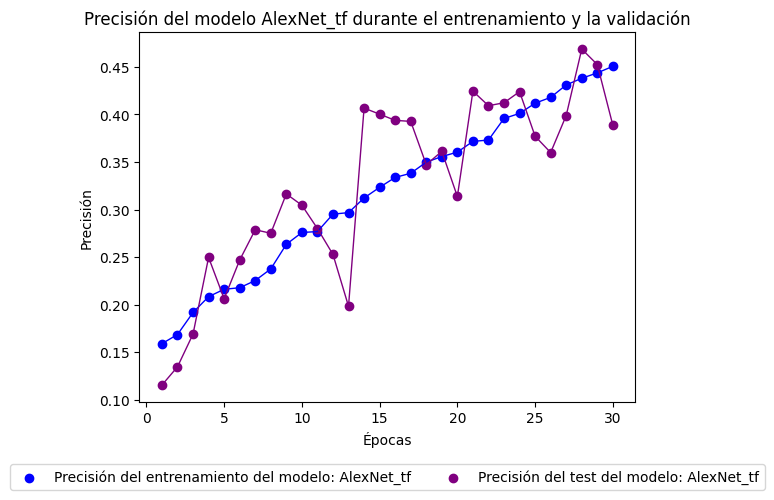

In [63]:
warnings.filterwarnings('ignore')
# Llamar a la función con AlexNet y su nombre
train_model_tf(AlexNet_tf, "AlexNet_tf", train_images, train_labels, test_images, test_labels,epochs,locBatchSize,save=True)

<h1>AlexNet en Pytorch desde cero

In [64]:
class AlexNet_torch(nn.Module):
    def __init__(self):
        super(AlexNet_torch, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=4)
        # Capa convolucional 2
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        # Capa convolucional 3
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        # Capa convolucional 4
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        # Capa convolucional 5
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)

        # Capa de aplanamiento
        self.flatten = nn.Flatten()

        # Capas densas
        self.fc1 = nn.Linear(9216, 4096)  # Después de pasar por las convoluciones y MaxPooling
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)  # 1000 clases en ImageNet
        self.fc4 = nn.Linear(1000, 10)  # 1000 clases en CIFAR-10

    def forward(self, x):
        # Propagación hacia adelante
        # Redimensionar las imágenes a 224x224
 #       x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)  # Resize

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = F.max_pool2d(x, kernel_size=3, stride=2)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)


        return x


Modelo AlexNet_torch tiene 62388354 parámetros entrenables.


Validating Epoch 30/30: 100%|█████████████████| 157/157 [00:30<00:00,  5.23it/s, val_accuracy=0.752]


Training accuracy for epoch 30, 75.23%, AlexNet_torch
Precisión para la clase 0, 82.10%, AlexNet_torch
Precisión para la clase 1, 90.90%, AlexNet_torch
Precisión para la clase 2, 62.70%, AlexNet_torch
Precisión para la clase 3, 58.10%, AlexNet_torch
Precisión para la clase 4, 75.80%, AlexNet_torch
Precisión para la clase 5, 64.70%, AlexNet_torch
Precisión para la clase 6, 75.90%, AlexNet_torch
Precisión para la clase 7, 79.40%, AlexNet_torch
Precisión para la clase 8, 86.10%, AlexNet_torch
Precisión para la clase 9, 76.60%, AlexNet_torch

Tiempo total de ejecución, 11577.01 segundos, AlexNet_torch


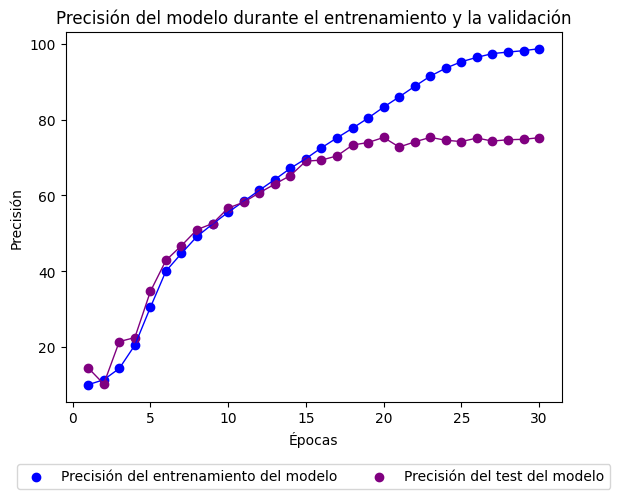

In [65]:
train_model_torch(AlexNet_torch, "AlexNet_torch", trainloader,
                             testloader, epochs, locBatchSize, save=True)

<h1> Modelo pre entrenado Alexnet en Pytorch

Ejecución de entrenamiento

In [52]:
warnings.filterwarnings('ignore')

#Load Pretrained AlexNet
model_AlexNet_pretrained = torchvision.models.alexnet(pretrained=True)
num_features = model_AlexNet_pretrained.classifier[6].in_features
model_AlexNet_pretrained.classifier[6] = nn.Linear(num_features, 10) # 10 output classes

Modelo model_AlexNet_pretrained tiene 57044810 parámetros entrenables.


Validating Epoch 10/10: 100%|██████████████████| 157/157 [00:26<00:00,  5.99it/s, val_accuracy=0.91]

Training accuracy for epoch 10, 95.66%, model_AlexNet_pretrained
Precisión para la clase 0, 88.60%, model_AlexNet_pretrained
Precisión para la clase 1, 96.30%, model_AlexNet_pretrained
Precisión para la clase 2, 91.20%, model_AlexNet_pretrained
Precisión para la clase 3, 72.30%, model_AlexNet_pretrained
Precisión para la clase 4, 92.50%, model_AlexNet_pretrained
Precisión para la clase 5, 89.40%, model_AlexNet_pretrained
Precisión para la clase 6, 95.30%, model_AlexNet_pretrained
Precisión para la clase 7, 94.80%, model_AlexNet_pretrained
Precisión para la clase 8, 95.60%, model_AlexNet_pretrained
Precisión para la clase 9, 94.40%, model_AlexNet_pretrained

Tiempo total de ejecución, 2652.99 segundos, model_AlexNet_pretrained


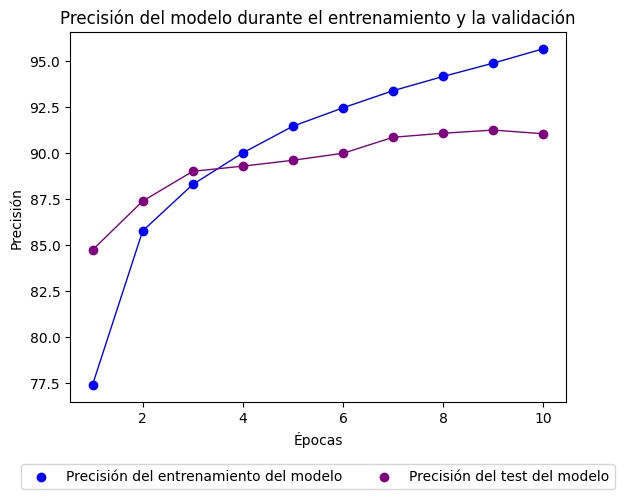

In [53]:
train_model_torch(model_AlexNe
                  
                  
                  t_pretrained, "model_AlexNet_pretrained", trainloader,
                             testloader, epochs_pretrained, locBatchSize, save=False,no_class=True)

<h1>VGG16 en TensorFlow pre-entrenado

In [54]:
def vgg16_tf_pretrain():
    # Cargar VGG16 con pesos preentrenados en ImageNet (sin congelar las capas)
    input_layer = Input(shape=(32, 32, 3))  # Entrada de tamaño 32x32
    x = Resizing(224, 224)(input_layer)  # Cambiar el tamaño a 224x224
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)
    
    # Congelar las capas base (para evitar que se actualicen durante el entrenamiento)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Añadir nuevas capas para la clasificación personalizada
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
 #   x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)  # Cambiar 10 por el número de clases en tu tarea
    
    # Crear el modelo final
    model = Model(inputs=input_layer, outputs=x)
    return model

Modelo vgg16_tf_pretrain tiene 12850698 parámetros entrenables.
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1080s 1s/step - accuracy: 0.4551 - loss: 3.1462 - val_accuracy: 0.5864 - val_loss: 1.3340
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1107s 1s/step - accuracy: 0.6470 - loss: 1.0754 - val_accuracy: 0.6495 - val_loss: 1.0649
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - accuracy: 0.6877 - loss: 0.9779 - val_accuracy: 0.5707 - val_loss: 1.7562
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 938s 1s/step - accuracy: 0.7179 - loss: 0.8803 - val_accuracy: 0.6439 - val_loss: 1.2345
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 937s 1s/step - accuracy: 0.7361 - loss: 0.8405 - val_accuracy: 0.6926 - val_loss: 1.0611
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 937s 1s/step - accuracy: 0.7530 - loss: 0.7867 - val_accuracy: 0.6665 - val_loss: 1.2805
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 941s 1s/step - accuracy: 0.7593 - loss: 0.7883 - val_accuracy: 0.6938 - val_loss: 1.1597
Epoch 8/10
782/782 ━━━━━━━━━━━━

Imprimiendo resultados: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 7686.10clase/s]

Accuracy for class plane: 68.20%, vgg16_tf_pretrain
Accuracy for class car: 81.10%, vgg16_tf_pretrain
Accuracy for class bird: 56.90%, vgg16_tf_pretrain
Accuracy for class cat: 62.90%, vgg16_tf_pretrain
Accuracy for class deer: 78.60%, vgg16_tf_pretrain
Accuracy for class dog: 23.70%, vgg16_tf_pretrain
Accuracy for class frog: 88.50%, vgg16_tf_pretrain
Accuracy for class horse: 81.30%, vgg16_tf_pretrain
Accuracy for class ship: 91.80%, vgg16_tf_pretrain
Accuracy for class truck: 82.00%, vgg16_tf_pretrain

Tiempo total de ejecución: 14541.24 segundos, vgg16_tf_pretrain


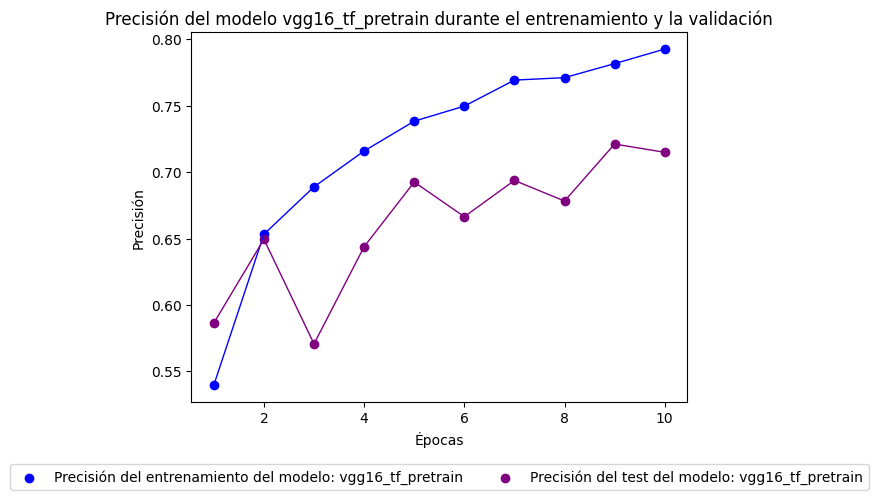

In [55]:
warnings.filterwarnings('ignore')

train_model_tf(vgg16_tf_pretrain, "vgg16_tf_pretrain", train_images, train_labels, 
               test_images, test_labels,epochs_pretrained,locBatchSize,save=False, no_def=False)

FIN

ffmogbaj@gmail.com

Fausto Morales

In [6]:

def AlexNet_tf2(input_shape=(32, 32, 3)):
    model = tf.keras.Sequential([
        # Primera capa convolucional con filtro más pequeño
        Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
        
        # Segunda capa convolucional
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
        
        # Tercera y cuarta capa convolucional
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        
        # Quinta capa convolucional
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
        
        # Aplanado y capas densas
        Flatten(),
        Dropout(0.5),
        
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        
        # Capa de salida con 10 clases para CIFAR-10
        Dense(10, activation='softmax')
    ])
    return model


Modelo AlexNet_tf2 tiene 8579658 parámetros entrenables.
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 92ms/step - accuracy: 0.2376 - loss: 23.5525 - val_accuracy: 0.4182 - val_loss: 10.6308
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.3717 - loss: 16.4961 - val_accuracy: 0.4233 - val_loss: 15.2301
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.4317 - loss: 17.4170 - val_accuracy: 0.3893 - val_loss: 22.3958
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 122s 157ms/step - accuracy: 0.4815 - loss: 26.9179 - val_accuracy: 0.2601 - val_loss: 100.5490
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - accuracy: 0.5304 - loss: 41.5683 - val_accuracy: 0.5061 - val_loss: 75.3042
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step - accuracy: 0.5865 - loss: 58.0100 - val_accuracy: 0.5898 - val_loss: 87.3491
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - accuracy: 0.6287 - loss: 72.3330 - val_accuracy: 0.6088 - val_loss: 90.8072
Epoch 8/15
7


Final validation accuracy: 74.01%, AlexNet_tf2
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


Imprimiendo resultados: 100%|█████████████████████████████████| 10/10 [00:00<00:00, 86125.34clase/s]

Accuracy for class plane: 66.10%, AlexNet_tf2
Accuracy for class car: 88.30%, AlexNet_tf2
Accuracy for class bird: 83.70%, AlexNet_tf2
Accuracy for class cat: 26.00%, AlexNet_tf2
Accuracy for class deer: 58.80%, AlexNet_tf2
Accuracy for class dog: 79.70%, AlexNet_tf2
Accuracy for class frog: 78.50%, AlexNet_tf2
Accuracy for class horse: 87.20%, AlexNet_tf2
Accuracy for class ship: 85.30%, AlexNet_tf2
Accuracy for class truck: 86.50%, AlexNet_tf2

Tiempo total de ejecución: 1446.25 segundos, AlexNet_tf2


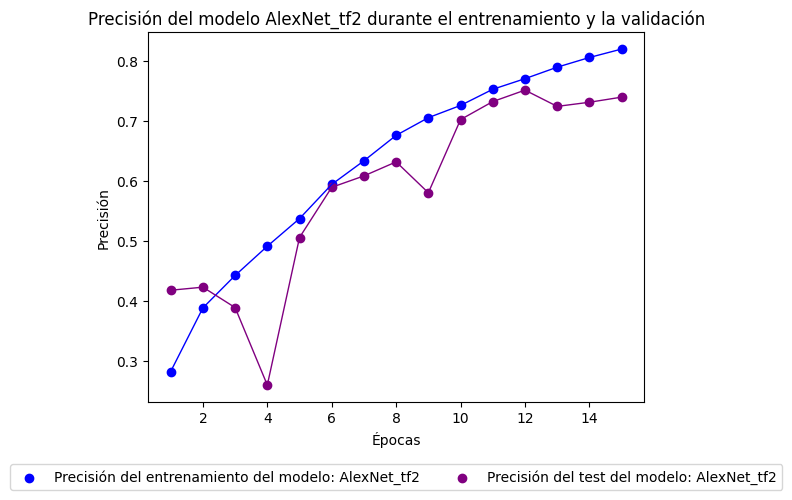

In [8]:
warnings.filterwarnings('ignore')
# Llamar a la función con AlexNet y su nombre
train_model_tf(AlexNet_tf2, "AlexNet_tf2", train_images, train_labels, test_images, test_labels,15,locBatchSize,save=True)